# Unit weighted regression accuracy

## Comparing simulation results

In this first section we will plot the error rate of unit-weighted regression in order to verify we match [Stucchio's simulation](https://www.chrisstucchio.com/blog/2014/equal_weights.html).

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt

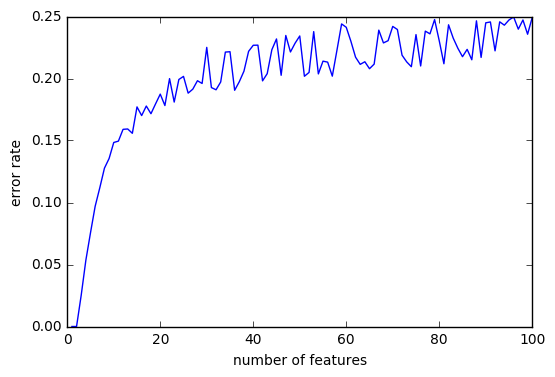

In [2]:
TRIALS = 10000
MAX_N = 100
stats = []
for n in xrange(1, MAX_N+1):
    errors = 0
    u = np.full(shape=n, fill_value=1.0/n)
    for _ in xrange(TRIALS):
        h = np.random.dirichlet(alpha=np.ones(n))
        x = np.random.randint(low=0, high=1+1, size=n)
        y = np.random.randint(low=0, high=1+1, size=n)
        if np.sign(np.dot(h, (x - y))) * np.sign(np.dot(u, (x - y))) < 0:
            errors += 1
    stats.append((n, float(errors) / TRIALS))
num_features, error_rate = zip(*stats)
plt.plot(num_features, error_rate)
plt.xlabel('number of features')
plt.ylabel('error rate')

Notice that if we plot all the errors, including those were a classifier doesn't give a prediction, the results are markedly different for small dimensions, though they converge for a higher number of features:

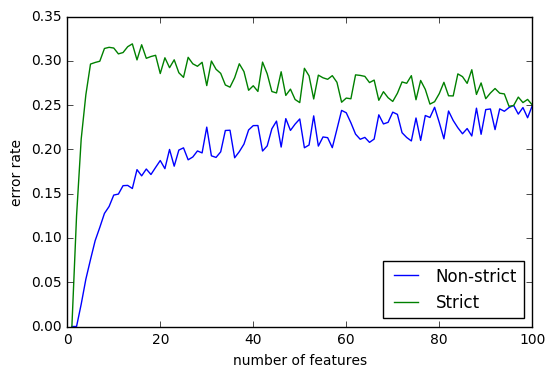

In [3]:
TRIALS = 10000
MAX_N = 100
stats = []
for n in xrange(1, MAX_N+1):
    errors = 0
    u = np.full(shape=n, fill_value=1.0/n)
    for _ in xrange(TRIALS):
        h = np.random.dirichlet(alpha=np.ones(n))
        x = np.random.randint(low=0, high=1+1, size=n)
        y = np.random.randint(low=0, high=1+1, size=n)
        if np.sign(np.dot(h, (x - y))) != np.sign(np.dot(u, (x - y))):
            errors += 1
    stats.append((n, float(errors) / TRIALS))
num_features, error_rate_strict = zip(*stats)
plt.plot(num_features, error_rate, label='Non-strict')
plt.plot(num_features, error_rate_strict, label='Strict')
plt.xlabel('number of features')
plt.ylabel('error rate')
plt.legend(loc='lower right')

## A faster simulation

We start by creating more efficient, vectorized code for doing simulations:

In [4]:
def compute_error_fraction_naive(n, samples=10000, strict_error=False):
    errors = 0
    u = np.full(shape=n, fill_value=1.0/n)
    for _ in xrange(samples):
        h = np.random.dirichlet(alpha=np.ones(n))
        x = np.random.randint(low=0, high=1+1, size=n)
        y = np.random.randint(low=0, high=1+1, size=n)
        if strict_error:
            if np.sign(np.dot(h, (x - y))) != np.sign(np.dot(u, (x - y))):
                errors += 1
        else:
            if np.sign(np.dot(h, (x - y))) * np.sign(np.dot(u, (x - y))) < 0:
                errors += 1
    return float(errors) / samples

def compute_error_fraction(n, samples=10000, strict_error=False):
    u = np.full(shape=n, fill_value=1.0/n)
    hv = np.random.dirichlet(alpha=np.ones(n), size=samples)
    xv = np.random.randint(low=0, high=1+1, size=(samples, n))
    yv = np.random.randint(low=0, high=1+1, size=(samples, n))
    row_dot = lambda a, b: np.einsum('ij,ij->i', a, b)
    if strict_error:
        diff = np.equal(np.sign(row_dot(hv, (xv - yv))), np.sign(np.dot(u, (xv - yv).T)))
    else:
        diff = np.sign(row_dot(hv, (xv - yv))) * np.sign(np.dot(u, (xv - yv).T)) >= 0
    return 1.0 - float(np.count_nonzero(diff)) / samples

print 'Strict error:',\
      compute_error_fraction_naive(3, strict_error=True),\
      compute_error_fraction(3, strict_error=True)
print 'Non strict error:',\
      compute_error_fraction_naive(3, strict_error=False),\
      compute_error_fraction(3, strict_error=False)
        
from timeit import timeit
print 'Time with naive version:', timeit(lambda: compute_error_fraction_naive(3, strict_error=True), number=10)
print 'Time with vectorized version:', timeit(lambda: compute_error_fraction(3, strict_error=True), number=10)

Strict error: 0.2077 0.2125
Non strict error: 0.0222 0.0253
Time with naive version: 1.68180608749
Time with vectorized version: 0.019434928894


Now we can redo the plots with less noise:

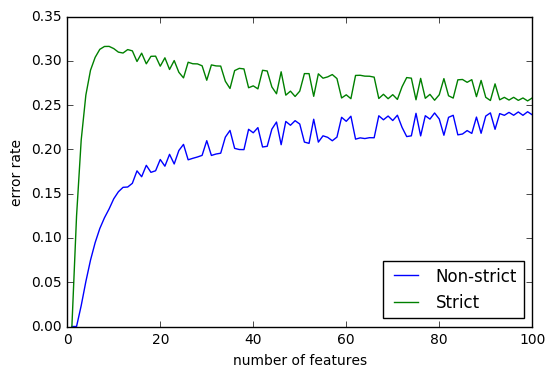

In [5]:
num_features = xrange(1, 100+1)
strict_error_rate = map(lambda n: compute_error_fraction(n, samples=1000000, strict_error=True), num_features)
non_strict_error_rate = map(lambda n: compute_error_fraction(n, samples=1000000, strict_error=False), num_features)
plt.plot(num_features, non_strict_error_rate, label='Non-strict')
plt.plot(num_features, strict_error_rate, label='Strict')
plt.xlabel('number of features')
plt.ylabel('error rate')
plt.legend(loc='lower right')

Quite curiously, there seems to be a special pattern even after we suppress the noise. The lower curve is clearly correlated with the upper one.

## Analyzing the difference between strict and non-strict cases

The only cases where there is a difference are those where one of the dot products is zero and the other isn't. The set of $h$ such that $h\cdot(x - y) = 0$ and $x \ne y$ has zero measure, then the only dot product that we expect could be zero is $u\cdot(x - y)$.

By the definition of $u$,

$u\cdot(x - y) = \frac{1}{n}\sum_i (x_i - y_i)$,

so the probability of a difference is equal to the probability of the sum of the components of $x - y$ being zero and $x \ne y$.

The sum of the components is a random variable distributed as the difference of two independent $B\left(n, \frac{1}{2}\right)$ random variables. The difference of $B\left(n, \frac{1}{2}\right)$ variables is a shifted binomial, as can be seen by noticing that $n - X \sim B\left(n, \frac{1}{2}\right)$ if $X \sim B\left(n, \frac{1}{2}\right)$, so $n + \sum_i (x_i - y_i) \sim B\left(2n, \frac{1}{2}\right)$.

If we want the probability of the sum of components being zero, it will be

$P\left(\sum_i (x_i - y_i) = 0\right) = \binom{2n}{n} \left(\frac{1}{2}\right)^{2n}$,

and subtracting the probability of both being equal we get

$P(\textrm{intermediate case}) = \frac{1}{2^{2n}}\binom{2n}{n} - \frac{1}{2^n}$.

Checking if it works:

In [9]:
cef_strict = compute_error_fraction(4, samples=1000000, strict_error=True)
cef_non_strict = compute_error_fraction(4, samples=1000000, strict_error=False)
print 'MC delta:', cef_strict - cef_non_strict
from math import factorial as fac
print 'Computed delta:', fac(2*4)/(fac(4)**2) * (1.0/(2 **(2*4))) - 1.0/(2**4)

MC delta: 0.210822
Computed delta: 0.2109375


Plotting it:

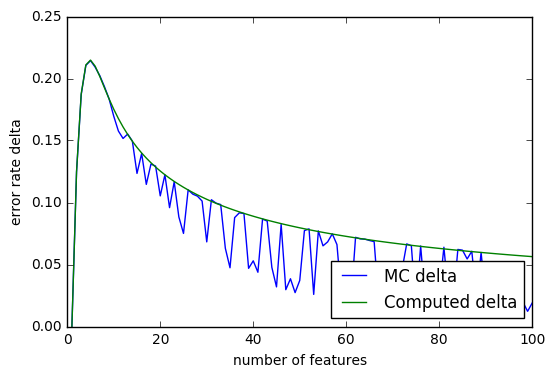

In [12]:
mc_delta = [ser - nser for ser, nser in zip(strict_error_rate, non_strict_error_rate)]
comp_delta = map(lambda n: fac(2*n)/(fac(n)**2) * (1.0/(2 **(2*n))) - 1.0/(2**n), num_features)
plt.plot(num_features, mc_delta, label='MC delta')
plt.plot(num_features,  comp_delta, label='Computed delta')
plt.xlabel('number of features')
plt.ylabel('error rate delta')
plt.legend(loc='lower right')

We are clearly having a smaller difference than expected in some cases, but the reasons are unclear and still to be investigated.

## Analyzing the $n = 2$ case

### Accurate simulation

Doing an accurate simulation for $n = 2$,

In [13]:
print 'Strict error fraction:', compute_error_fraction(2, samples=1000000, strict_error=True)
print 'Non-strict error fraction:', compute_error_fraction(2, samples=1000000, strict_error=False)

Strict error fraction: 0.125036
Non-strict error fraction: 0.0


we find the non-strict error fraction is exactly zero, while the strict one is around 12.5%.

### Non-strict error fraction

Our vector $h$ can be written as $\frac{1}{2}[1+\alpha\;1-\alpha]^T$, where $\alpha$ is a $\mathcal{U}(-1, 1)$ random variable. Let $d = x - y$, then the dot product inequality can be expressed as follows:

$(h \cdot d)(u \cdot d) < 0$

$\frac{1}{4}((d_1 + d_2) + \alpha (d_1 - d_2))(d_1 + d_2) < 0$

$(d_1 + d_2)^2 + \alpha (d_1^2 - d_2^2) < 0$

The first term is positive and WLOG we can assume $d_1^2 \le d_2^2$. Then the expression will take its minimum value for $\alpha = 1$. Substituting,

$d_1^2 + 2 d_1 d_2 + d_2^2 + d_1^2 - d_2^2 < 0$

$2 d_1^2 + 2 d_1 d_2 < 0$

we can see that the inequality will only be true iff either $d_1$ or $d_2$ is negative, $|d_1|$ is strictly smaller than $|d_2|$ and nonzero. For the case of our binomial vectors, $|d_i| \le 1$, so the conditions cannot be satisfied.

### Strict error fraction

